In [1]:
import matplotlib
import phonopy
import numpy as np
import API_phonopy as api_ph
import BTE_GreensFunction as BTEGF
import matplotlib.pyplot as plt
from matplotlib import cm, ticker 
from phonopy.units import VaspToTHz, EV, Angstrom, Kb, THz, THzToEv, Hbar

In [2]:
# Basic setups. 
Lmin = 1
Lmax = 100
Grating_um = np.logspace(np.log10(Lmin),np.log10(Lmax),201)
L_Angstrom = Grating_um*1e4
T0 = 100 # Temperature
mesh = [24,24,10]#
Nrepeat_fc2 = [5,5,3] 

x_direct = [0] # this is a tuple/list object
Nt = 101

# this doe sn't really matter. for calculations, as all velocities are input from BTE
poscar = 'POSCAR' 


is_isotope = True # include isotope
four_phonon = False # you will need to calculate 4ph scatterings 
write_data = True
lowOrder = False

# ------------------------------------- ShengBTE calculated phonon props -------------------------------------#
BTE_Folder = './Qmesh-242410/'
Dir_BTE_HarPhons = BTE_Folder+'BTE/' #remember to end with /
Dir_BTE_lifetime = BTE_Folder + 'T' + str(T0) +'K/'
Dir_BTE_MFD = BTE_Folder + 'T' + str(T0) +'K/' # set the same as RTA, then MFD is mean free path.
# ------------------------------------ Params to calculate Callaway GF ---------------------------------------#

D_boundary = 10e-6


In [3]:
# ----------------------------- Creating Phonon objects carrying BZ and qmesh ----------------------------------#
phonon = phonopy.load(unitcell_filename=poscar,
                      supercell_matrix=Nrepeat_fc2,
                      force_constants_filename='FORCE_CONSTANTS') # load with POSCAR and FORCE_SETS

fc2 = phonon.force_constants
phonon.run_mesh(mesh,is_gamma_center=True) 
# make gamma centered to be consistent with phono3py & ShengBTE

qpoints = phonon.get_mesh_dict()['qpoints']
w_qgrid = phonon.get_mesh_dict()['weights']
(Nqired,Ns) = phonon.get_mesh_dict()['frequencies'].shape #irreducible.
Wmat_grid = np.reshape(np.repeat(w_qgrid,Ns).T,(Nqired,Ns))
rots_qpoints = BTEGF.get_qpoint_rotsym(phonon) # rotations at q points.


qpoints_full,Vec_freqs,Vec_cqs,Vec_vqs,Vec_Fsc_qs,Vec_tau_qs,Vec_tauN_qs,Vec_tauR_qs,kappa_cvF,Nratio_qs = BTEGF.load_ShengBTE_Phonons(T0,phonon,Dir_BTE_HarPhons,Dir_BTE_MFD,Dir_BTE_lifetime,D_boundary,is_isotope,four_phonon)

Vec_FA_qs = Vec_Fsc_qs/Angstrom
kappa_qs = Vec_cqs*Vec_vqs[0]*Vec_FA_qs[0] # modal conductivity
kappa_total = np.sum(kappa_qs)*EV/Angstrom*THz
C0 = np.sum(Vec_cqs)


/home/xinqian/Softwares/anaconda3/lib/python3.9/site-packages/phonopy/phonon/thermal_properties.py:43: RuntimeWarning: invalid value encountered in true_divide
  return Kb * x ** 2 * expVal / (expVal - 1.0) ** 2
/home/xinqian/Softwares/API_Phonons/BTE_GreensFunction.py:420: RuntimeWarning: divide by zero encountered in true_divide
  tau_ph = 1./(scatt_rate_N+scatt_rate_U)
/home/xinqian/Softwares/API_Phonons/BTE_GreensFunction.py:421: RuntimeWarning: divide by zero encountered in true_divide
  tau_N = 1./scatt_rate_N # ps.
/home/xinqian/Softwares/API_Phonons/BTE_GreensFunction.py:424: RuntimeWarning: divide by zero encountered in true_divide
  tau_qs = 1./(scatt_rate_N+scatt_rate_U+scatt_rate_I+scatt_rate_b)
/home/xinqian/Softwares/API_Phonons/BTE_GreensFunction.py:318: RuntimeWarning: invalid value encountered in double_scalars
  Vec_tau_sc[iqs] += Num/Den/weights[iq] # rescaled relaxatio time.
/home/xinqian/Softwares/API_Phonons/BTE_GreensFunction.py:510: RuntimeWarning: divide by zer

In [4]:
Lifetime_data = np.array([Vec_freqs,Vec_tauN_qs,Vec_tauR_qs])
api_ph.write_2D_array('Lifetimes_T{}K.txt'.format(T0),Lifetime_data)

In [5]:
k = 2*np.pi/np.flip(L_Angstrom)# Grating wavevector of TTG
k_um = 1/np.flip(Grating_um)

alpha,v0,eta,gamma = BTEGF.get_momentum_transCoeffs(k,Vec_cqs,Vec_vqs,Vec_FA_qs,Vec_freqs,Vec_tau_qs,Vec_tauR_qs,Vec_tauN_qs, Nratio_qs,phonon,rots_qpoints)

omega_plus,omega_minus,vss = BTEGF.get_secsound_dispersion(k,alpha,eta,v0,gamma,lowOrder=lowOrder)

kEPs =  0.03548133892335755 0.2570395782768864
Graing LEP= 3.890451449942806 28.183829312644534


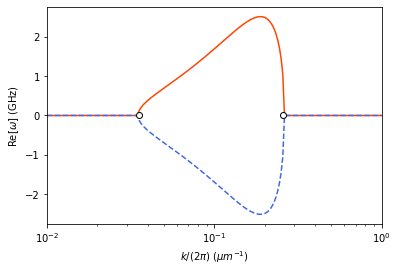

In [6]:
plt.semilogx(k_um,omega_plus.real*1000,color='orangered')
plt.semilogx(k_um,omega_minus.real*1000,'--',color='royalblue')

# THis is only valid for low-order.

APT_broken = omega_plus.real>0
k_ss_region = k_um[APT_broken]
kEP1 = k_ss_region[0]
Im_w_ss_region = omega_plus.imag[APT_broken]
Im_omega_EP1 = Im_w_ss_region[0]

if lowOrder:
    plt.plot(kEP1,0,'o',color='white',mec='black')
else:
    kEP2 = k_ss_region[-1]
    Im_omega_EP2 = Im_w_ss_region[-1]
    plt.plot(kEP1,0,'o',kEP2,0,'o',color='white',mec='black')
    

plt.xlim([np.min(k_um),np.max(k_um)])
#plt.ylim([-12,12])
plt.xlabel('$k/(2\pi)$ ($\mu m^{-1}$)')
plt.ylabel('Re[$\omega$] (GHz)')

Disp = np.array([k_um,omega_plus.real*1000,omega_minus.real*1000,omega_plus.imag*1000,omega_minus.imag*1000])
api_ph.write_2D_array('Disp_omega_T'+str(T0)+'K.txt',Disp,'# k (um^-1)  Re_wp  Re_wm Im_wp   Im_wm')

print('kEPs = ',kEP1,kEP2)
print('Graing LEP=',1/kEP2, 1/kEP1)

Text(0, 0.5, '-Im[$\\omega$] (GHz)')

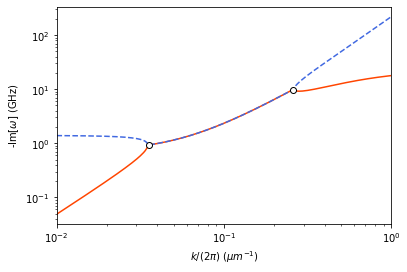

In [7]:
plt.loglog(k_um,-omega_plus.imag*1000,color='orangered')
plt.loglog(k_um,-omega_minus.imag*1000,'--',color='royalblue')
if lowOrder: 
    plt.semilogy(kEP1,-Im_omega_EP1*1000,'o',color='white',mec='black')
else:
    plt.semilogy(kEP1,-Im_omega_EP1*1000,'o',kEP2,-Im_omega_EP2*1000,'o',color='white',mec='black')
plt.xlim([np.min(k_um),np.max(k_um)])
#plt.ylim([1e-1,100])
plt.xlabel('$k/(2\pi)$ ($\mu m^{-1}$)')
plt.ylabel('-Im[$\omega$] (GHz)')

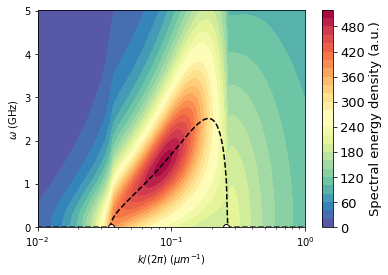

In [8]:
# Compute Spectral energy density
K,OMEGA,SpecFunc = BTEGF.calc_SED_secsound(k_um,omega_plus)
plt.contourf(K,OMEGA*1000,SpecFunc,cmap='Spectral_r',levels=25)
plt.plot(k_um,omega_plus.real*1000,'--',color='black')
if lowOrder:
    plt.plot(kEP1,0.0001,'o',color='white',mec='black')
else:
    plt.plot(kEP1,0.0001,'o',kEP2,0.0001,'o',color='white',mec='black')

plt.xscale('log')
plt.xlim([np.min(k_um),np.max(k_um)])
#plt.ylim([0,100])
#plt.clim([0,300])
plt.xlabel('$k/(2\pi)$ ($\mu m^{-1}$)')
plt.ylabel('$\omega$ (GHz)')
plt.rcParams.update({'font.size': 13})

cbar = plt.colorbar()
cbar.set_label('Spectral energy density (a.u.)')
plt.savefig("SpectralFunc" +str(T0)+ "K.svg",dpi=600,bbox_inches='tight')

Dipping depth and time:  -0.141620946327819 1.5


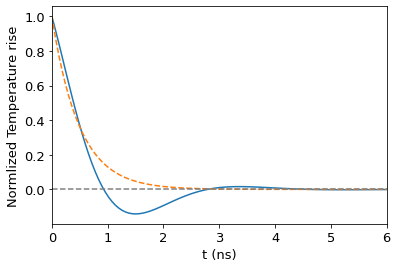

In [9]:
L0_um = 10
tmax = 6

alphaF = np.sum(kappa_qs)/np.sum(Vec_cqs)
k0 = 2*np.pi/(L0_um*1e4)
alpha0,v00,eta0,gamma0 = BTEGF.get_momentum_transCoeffs(k0,Vec_cqs,Vec_vqs,Vec_FA_qs,Vec_freqs,
                                                        Vec_tau_qs,Vec_tauR_qs,Vec_tauN_qs,
                                                        Nratio_qs,phonon,rots_qpoints)
#tmax = np.round(15*L0_um/v00)[0] + 1
omega_plus0,omega_minus0,vss0 = BTEGF.get_secsound_dispersion(k0,alpha0,eta0,v00,gamma0,lowOrder=lowOrder)
wssp_GHz = omega_plus0.real*1e3
gssp_GHz = omega_plus0.imag*1e3

wssm_GHz = omega_minus0.real*1e3
gssm_GHz = omega_minus0.imag*1e3

t_ns = np.linspace(0,tmax,Nt)
T1 = np.exp(gssp_GHz*t_ns/2)*np.cos(wssp_GHz*t_ns) 
TF = np.exp(-alpha0*k0**2*1e3*t_ns)

plt.plot(t_ns,T1,t_ns,TF,'--')
plt.plot(t_ns,0*t_ns,'--',color='gray')
plt.xlim([0,np.max(t_ns)])
#plt.ylim([-0.3,1])
plt.xlabel('t (ns)')
plt.ylabel('Normlized Temperature rise')

Data = np.array([t_ns,T1,TF])
api_ph.write_2D_array('TTG_L'+str(L0_um)+'um_T'+str(T0)+'K.txt',Data)
print('Dipping depth and time: ',T1.min(),t_ns[T1==T1.min()][0])

In [10]:
# L0_scan = np.logspace(-1,3,41)

# Dips = []

# for L0_um in L0_scan:
#     #print(L0_um)
#     k0 = 2*np.pi/(L0_um*1e4)
#     #print(k0)
#     alpha0,v00,eta0,gamma0 = BTEGF.get_momentum_transCoeffs(k0,Vec_cqs,Vec_vqs,Vec_FA_qs,Vec_freqs,
#                                                             Vec_tau_qs,Vec_tauR_qs,Vec_tauN_qs,
#                                                             Nratio_qs,phonon,rots_qpoints)
#     tmax = np.round(50*L0_um/v00)
#     omega_plus0,omega_minus0,vss0 = BTEGF.get_secsound_dispersion(k0,alpha0,eta0,v00,gamma0,lowOrder=lowOrder)
#     wssp_GHz = omega_plus0.real*1e3
#     gssp_GHz = omega_plus0.imag*1e3

#     wssm_GHz = omega_minus0.real*1e3
#     gssm_GHz = omega_minus0.imag*1e3

#     t_ns = np.linspace(0,tmax,Nt)
#     T1 = np.exp(gssp_GHz*t_ns/2)*np.cos(wssp_GHz*t_ns) #+ np.exp(gssm_GHz*t_ns/2)*np.cos(wssm_GHz*t_ns)
#     Dip = np.min([0,T1.min()])
#     print(T0,L0_um,Dip)